# Desarrollo Generador PatchGAN
Notebook de desarrollo y pruebas del Generador
- Encoder (VGG 16/IMGENET)
- Bottleneck
- Atention
- Decoder (Unet)
- Output

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cpu


## 1) Data Loader for images

In [2]:
import sys
from pathlib import Path
sys.path.insert(0, str(Path.cwd().parent.parent))

In [24]:
from torch.utils.data import DataLoader
from image_driver import ColorizationDataset

dataset = ColorizationDataset("../../ImagesProcessed/color", num_classes=8)
loader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=4)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


La clase `ColorizationDataset` ubicada en la raiz del directorio es un procesador intermedio con funciones como `_get_item()` entre otras para facilitar el traslado de informacion. Debido a que se estara utilizando principalmente la codificacion de color LAB en lugar de RGB, es necesario separar los canales de luminocidad de los A y B. 

In [38]:
first_batch = next(iter(loader))
gray, ab_color, label = first_batch

print("Grayscale: ",gray.shape)
print("AB Color: ",ab_color.shape)
print("Label OneHot encoder: ",label.shape)


Grayscale:  torch.Size([16, 1, 128, 128])
AB Color:  torch.Size([16, 2, 128, 128])
Label OneHot encoder:  torch.Size([16, 8])


- Grayscale: B, 1, 128, 128
Para imagenes de 1 canal de 128x128 de resolucion. el B es por el tamaño del batch

- AB Color: B, 2, 128, 128
Para el encoding de LAB, poemos imaginar la imagen en blanco y negro como el canal de luminosidad (L) por tanto, el color solo debede ser de dos canales AB y 128x128 para las imagenes

- Label: B, 8
Dado que tenemos 8 posibles categorias para las imagenes con el fin de ayudar a mejorar tecnicas especificas dependiendo del contexto semantico de las imagenes, aplicamos un OneHot encoder, y a esto refiere esta variable

## 2) Discriminador
Las pruebas e instanciacion estan presentes en el notebook `prueba_discriminador.ipynb`. En este documento, solo se utilizara para evaluar preliminarmente la generacion de las imagenes.

In [5]:
from Modelo.discriminador import (
    PatchGANDiscriminator,
    DiscriminatorLoss,
    init_discriminator_weights,
    RECOMMENDED_CONFIG
)
# Crear discriminador
D = PatchGANDiscriminator(
    input_channels=3,
    features=64
).to(device)

# Inicializar pesos
init_discriminator_weights(D)

# Info del modelo
print(f"Discriminador creado")
print(f"   Parámetros: {D.get_num_params():,}")

Discriminador creado
   Parámetros: 2,765,633


## 3) Generador

In [18]:
%load_ext autoreload
%autoreload 2
from Modelo.generador import ColorGenerator

G = ColorGenerator().to(device)
num_prams = sum(p.numel() for p in G.parameters())

print(f"Generador creado")
print(f"   Parámetros: {num_prams:,}")

c:\Users\JM\Documents\DeepLearning\ImageColoringGAN\.gancolor\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\JM\Documents\DeepLearning\ImageColoringGAN\.gancolor\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Generador creado
   Parámetros: 18,700,576


In [19]:
gray = torch.randn(1, 1, 128, 128)
label = torch.randn(1, 8)
with torch.no_grad():
    out = G(gray, label)
print(out.shape)

torch.Size([1, 2, 128, 128])


- **Recibe** -> `[B, 1, 128, 128]` y `[B, 8]`
correspondiente al canal de luminosidad o imagen en blnco y negro y la label

- **Devuelve** -> `[B, 2, 128, 128]`
Correspondiente a los canales AB de la imagen. No necesitamos generar 3 canales nuevos para RGB, sino que podemos aprovechar la informacion presente en el canal de luminosidad. Esto simplifica considerableente el modelo y mantiene la brillantez de las imagenes.


## 4) Criterios y optimizadores de GAN

Para los optimizadores se considera

- **Criterio global el GAN**
`BCEWithLogitsLoss` combina la activacion sigmoide a la LogLoss binaria del discriminador. Es la decision mas estable para definir el criterio de perdida del GAN, pues es bien concido y ha demostrado buenos resultados en redes adversarias.
- **Criterio l1:**
`L1Loss`
- **Optimizador de Generador**
`Adam` con  `learning rate` de 2e-4 y `betas` de (0.5, 0.999).
Los betas refieren al momentum y alisamiento de los gradientes. El beta1 defacto es 0.9 pero este tiende a ser muy grande para redes adversarias donde el aprendizaje es distribuido entre dos redes, por eso se disminuyo an un valor intermedio de 0.5. El alizamiento se mantuvo con el valor default.
- **Optimizador de Discriminador**
Explicados en pruebas de discriminador

In [ ]:
import torch.optim as optim

# Criterios
criterion_gan = nn.BCEWithLogitsLoss()
criterion_l1 = nn.L1Loss()

# Optimizadores de G y D
optim_G = optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))
optim_D = torch.optim.Adam(
    D.parameters(),
    lr=RECOMMENDED_CONFIG['learning_rate'],
    betas=RECOMMENDED_CONFIG['betas']
)

Lo siguiente solo define una fucion para poder guardar en un formato entendible, diferentes samples para el bucle de entrenamiento. Convierte el formato LAB a RGB y pone titulos para un mejor analisis de los resultados

In [33]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import lab2rgb

CATEGORY_MAP = {
    1: "airplane",
    2: "car",
    3: "cat",
    4: "dog",
    5: "flower",
    6: "fruit",
    7: "motorbike",
    8: "person"
}

def save_fake_color(gray, fake_ab, real_ab, epoch, label, out_dir="samples", max_samples=4):
    os.makedirs(out_dir, exist_ok=True)
    num_samples = min(max_samples, gray.size(0))

    fig, axes = plt.subplots(num_samples, 3, figsize=(9, 3 * num_samples))
    if num_samples == 1:
        axes = np.expand_dims(axes, 0)  # ensure iterable shape

    for i in range(num_samples):
        L = (gray[i, 0].cpu().numpy() + 1.0) * 50.0       # de-normalize L
        real_ab_np = real_ab[i].cpu().numpy() * 110.0
        fake_ab_np = fake_ab[i].detach().cpu().numpy() * 110.0

        # Convert LAB → RGB
        def lab_to_rgb(L, ab):
            lab = np.zeros((L.shape[0], L.shape[1], 3))
            lab[:, :, 0] = L
            lab[:, :, 1:] = ab.transpose(1, 2, 0)
            rgb = np.clip(lab2rgb(lab), 0, 1)
            return rgb

        gray_img = np.repeat((L / 100.0)[..., None], 3, axis=2)
        real_rgb = lab_to_rgb(L, real_ab_np)
        fake_rgb = lab_to_rgb(L, fake_ab_np)

        # Display images
        imgs = [gray_img, real_rgb, fake_rgb]
        titles = ["Grayscale", "Real Color", "Fake Color"]

        for j, ax in enumerate(axes[i]):
            ax.imshow(imgs[j])
            ax.axis("off")
            ax.set_title(titles[j])

        # Add label name on the left side
        name = CATEGORY_MAP[label.argmax().item()+1]
        axes[i, 0].set_ylabel(name, rotation=0, labelpad=45, fontsize=10, va='center')

    plt.tight_layout()
    save_path = os.path.join(out_dir, f"epoch_{epoch}_{name}.png")
    plt.savefig(save_path)
    plt.close(fig)


## 5) Short-Training
Se definio un corto periodo de entrenaminto para evauluar un funcionamiento adecuado del mdelo. Se limita la cantidad de tandas evaluadas y las epocas son solo 10. Asimismo, cada epoca se guarda una iagen de sample para ejemplificar el rendimiento de la epoca

In [39]:
epochs = 10
batch_size = 2
max_batch = 32

## Saiving intermedaite
os.makedirs("samples", exist_ok=True)

## Miniloader (1 worker, batch size of 4)
mini_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
print(f"Training started! {epochs} Epochs, {max_batch} batches, {batch_size} images")
for epoch in range(epochs):
    for i, (gray, ab_color, labels) in enumerate(mini_loader):
        # Limite para short-train
        if i * gray.size(0) >= max_batch:
            break
        
        # Data loading
        gray = gray.to(device)
        ab_color = ab_color.to(device)
        labels = labels.to(device)
        
        # 1. Discriminador
        #### Real
        optim_D.zero_grad()
        fake_color = G(gray, labels)
        real_input = torch.cat([
            gray, ab_color
        ], dim=1)
        real_pred = D(real_input)
        loss_real = criterion_gan(
            real_pred, torch.ones_like(real_pred)
        )
        
        ### Falso
        fake_input = torch.cat([gray, fake_color.detach()], dim=1)
        fake_pred = D(fake_input)
        loss_fake = criterion_gan(
            fake_pred,
            torch.zeros_like(fake_pred)
        )
        
        ## Perdida deiscrimiador
        loss_D = (loss_real + loss_fake) * 0.5
        loss_D.backward()
        optim_D.step()
        
        # 2. Generador
        optim_G.zero_grad()
        fake_pred = D(fake_input)
        loss_G_gan = criterion_gan(
            fake_pred,
            torch.ones_like(fake_pred)
        )
        loss_G_l1 = criterion_l1(
            fake_color, ab_color
        ) * 100.0
        
        loss_G = loss_G_gan + loss_G_l1
        loss_G.backward()
        optim_G.step()
        
        print(f"(Epoch {epoch}) Batch {i} | D = {loss_D:.5f} | G = {loss_G:.5f}", end="\r",  flush=True)
      
    # Fetch images for sampling  
    with torch.no_grad():
        G.eval()
        sample_color = ab_color[:4]
        sample_gray = gray[:4]
        sample_labels = labels[:4]
        sample_fake = G(sample_gray, sample_labels)
        G.train()

        save_fake_color(sample_gray, sample_fake,sample_color, epoch, sample_labels, max_samples=1)
    
    print(f"Epoch {epoch} | D={loss_D.item():.3f} | G={loss_G.item():.3f}", end="\r",  flush=True)
    print("")
    
    

Training started! 10 Epochs, 32 batches, 2 images
Epoch 0 | D=0.076 | G=17.6667629 | G = 17.66604
Epoch 1 | D=0.065 | G=13.2256473 | G = 13.22496
Epoch 2 | D=0.027 | G=11.6292711 | G = 11.62898
Epoch 3 | D=0.167 | G=6.17616725 | G = 6.176156
Epoch 4 | D=0.281 | G=7.44628092 | G = 7.445929
Epoch 5 | D=0.102 | G=7.38310244 | G = 7.382596
Epoch 6 | D=0.014 | G=8.74501404 | G = 8.744572


C:\Users\JM\AppData\Local\Temp\ipykernel_16996\708773239.py:36: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 123 negative Z values that have been clipped to zero
  rgb = np.clip(lab2rgb(lab), 0, 1)


Epoch 7 | D=0.040 | G=6.947
Epoch 8 | D=0.250 | G=7.06825047 | G = 7.067872
Epoch 9 | D=0.302 | G=8.33630169 | G = 8.336273


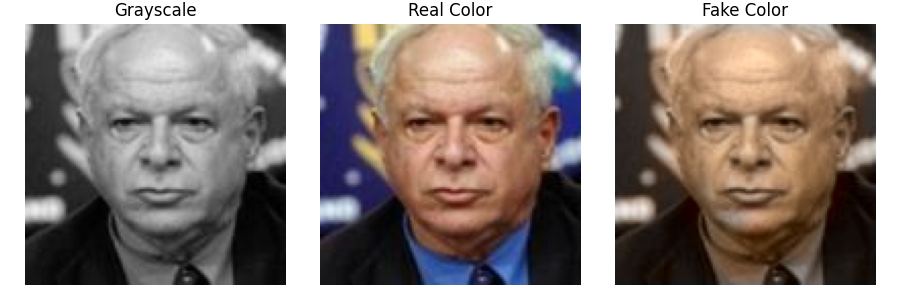

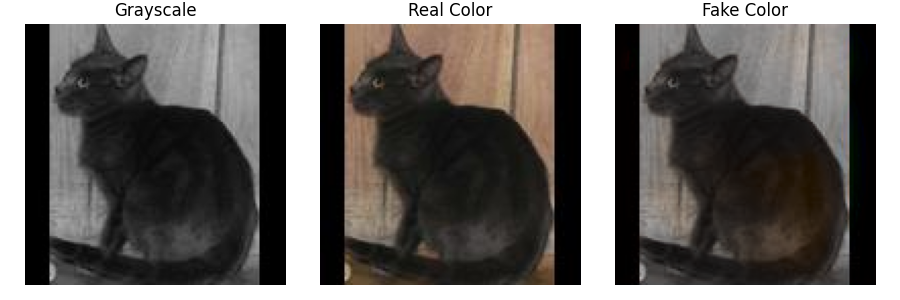

In [42]:
from IPython.display import Image, display

display(Image(filename='samples/epoch_8_person.png'))
display(Image(filename='samples/epoch_9_cat.png'))